# Example for integration with HyperSpy lazy signals

This notebook shows how to process a HyperSpy [lazy signal](http://hyperspy.org/hyperspy-doc/current/user_guide/big_data.html) using LiberTEM and how to create a HyperSpy lazy signal from a LiberTEM DataSet. It uses PyXem for scanning diffraction data support

Please note that these features are rather new and not well-tested yet. Bug reports and improvements are much appreciated!

In [1]:
%matplotlib nbagg

In [2]:
import os

import hyperspy.api as hs
import pyxem
import matplotlib.pyplot as plt
import distributed as dd

from libertem.api import Context
from libertem.executor.dask import DaskJobExecutor
from libertem.executor.concurrent import ConcurrentJobExecutor
from libertem.udf.sumsigudf import SumSigUDF
from libertem.contrib.daskadapter import make_dask_array

In [3]:
# Use a LiberTEM executor that plays well with the curren Dask scheduler
ctx = Context.make_with("dask-integration")

# Alternatively, one could use the LiberTEM Dask scheduler as default Dask scheduler
# Unfortunately, the current BLO reader in Hyperspy doesn't play well with the distributed scheduler
# ctx = Context.make_with("dask-make-default")

In [4]:
data_base_path = os.environ.get("TESTDATA_BASE_PATH", "/cachedata/alex/libertem-test-data/")
path = os.path.join(data_base_path, "default.blo")

## Load data as HyperSpy lazy signal

In [5]:
lazy_4d = hs.load(path, lazy=True)

In [6]:
lazy_4d

<LazyDiffraction2D, title: , dimensions: (121, 90|144, 144)>

In [7]:
type(lazy_4d.data)

dask.array.core.Array

[########################################] | 100% Completed |  0.1s


<IPython.core.display.Javascript object>


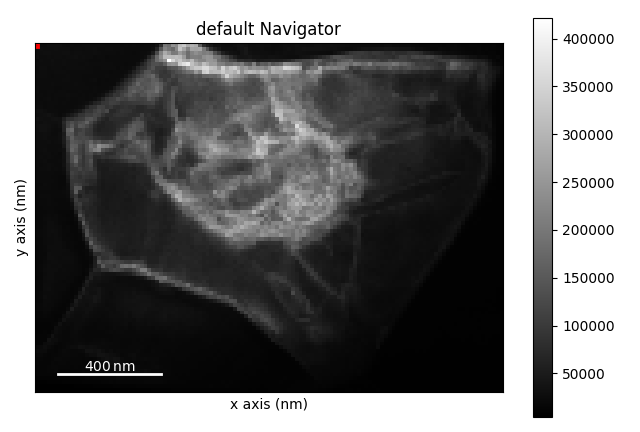

<IPython.core.display.Javascript object>


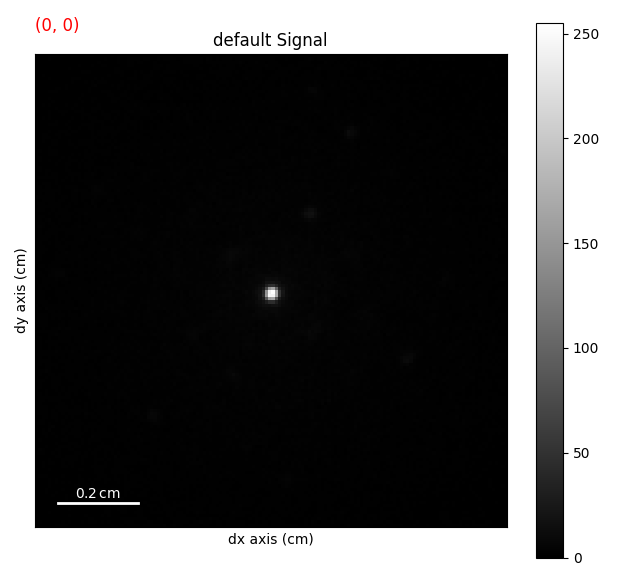

In [8]:
# NBVAL_IGNORE_OUTPUT
lazy_4d.plot()

## Load the underlying Dask array of the HyperSpy lazy signal as a LiberTEM dataset

In [9]:
dask_ds = ctx.load("dask", lazy_4d.data, sig_dims=2)

In [10]:
pick_a = ctx.create_pick_analysis(dataset=dask_ds, y=45, x=60)
pick_res = ctx.run(pick_a)

In [11]:
sum_res = ctx.run_udf(dataset=dask_ds, udf=SumSigUDF())

In [12]:
%%timeit
# NBVAL_SKIP
sum_res = ctx.run_udf(dataset=dask_ds, udf=SumSigUDF())

314 ms ± 3.35 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<IPython.core.display.Javascript object>


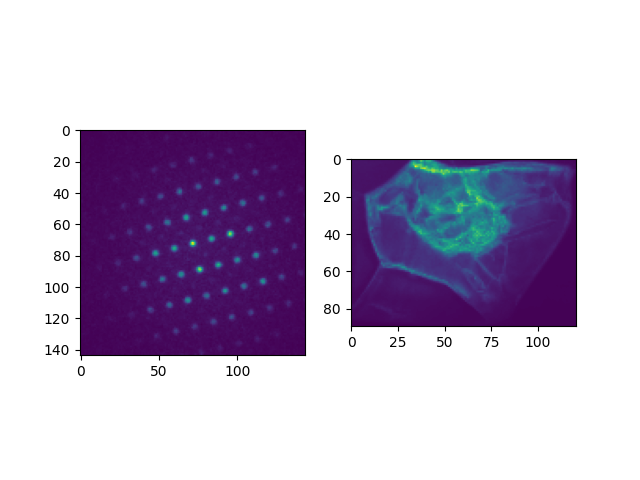

In [13]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(pick_res['intensity'].raw_data)
axes[1].imshow(sum_res['intensity'].data)

## Load data using LiberTEM

In [14]:
native_ds = ctx.load('auto', path)

In [15]:
sum_res = ctx.run_udf(dataset=native_ds, udf=SumSigUDF())

In [16]:
%%timeit
# NBVAL_SKIP
sum_res = ctx.run_udf(dataset=native_ds, udf=SumSigUDF())

269 ms ± 1.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Create dask array from LiberTEM dataset

In [17]:
dask_array, workers = make_dask_array(native_ds)

## Create lazy HyperSpy signal from Dask array

In [18]:
libertem_4d = pyxem.signals.LazyDiffraction2D(dask_array)

[########################################] | 100% Completed |  0.5s


<IPython.core.display.Javascript object>


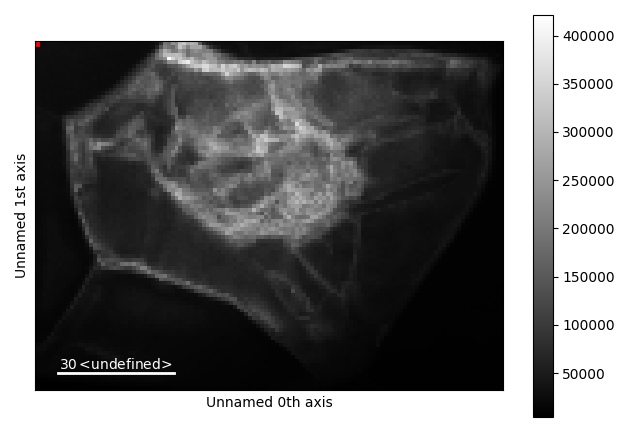

<IPython.core.display.Javascript object>


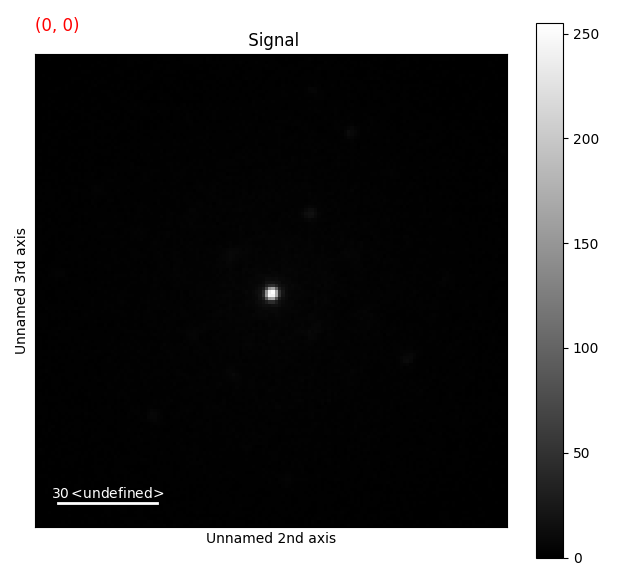

In [19]:
# NBVAL_IGNORE_OUTPUT
libertem_4d.plot()